In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch

import gb1
import models
from utils import str2onehot
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

MODEL_PATH = '/data/wongfanc/gb1-models/'

In [95]:
# load training sequences
fname = '/data/wongfanc/gb1-models/gb1-h10-5k-030123-train-idx.npz'
d = np.load(fname)
train_idx = d['train_idx'][: 5000]

df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()

trainseq_n = [seq_n[i] for i in train_idx]
ytrain_n = np.array([y_n[i] for i in train_idx])

0.8 -3.9436077044558915
0.9 -2.53016871485038
0.95 -0.7911715915478643
0.98 0.35361658488812653
0.99 0.9506659969115955


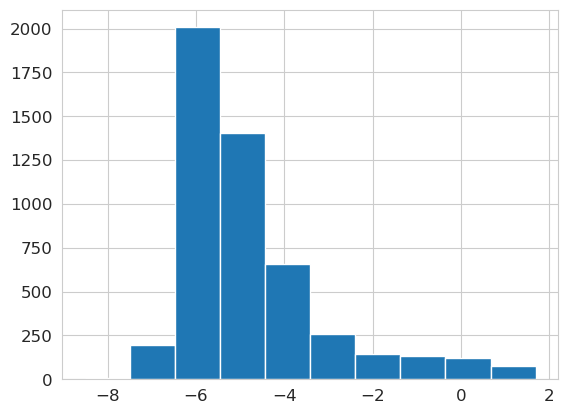

In [99]:
plt.hist(ytrain_n);
for q in [0.8, 0.9, 0.95, 0.98, 0.99]:
    print(q, np.quantile(ytrain_n, q))

One-hot encoded sequences to shape = (5000, 4, 21) (0 sec)
4500 training data points with 34.0 positive, 500 validation data points with 5.0 positive.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 188.40it/s]


Epoch 0. Train loss: 0.69. Val loss: 0.69. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 188.78it/s]


Epoch 1. Train loss: 0.65. Val loss: 0.68. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 177.96it/s]


Epoch 2. Train loss: 0.54. Val loss: 0.63. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 186.34it/s]


Epoch 3. Train loss: 0.40. Val loss: 0.52. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 176.48it/s]


Epoch 4. Train loss: 0.30. Val loss: 0.44. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 195.13it/s]


Epoch 5. Train loss: 0.21. Val loss: 0.38. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 182.11it/s]


Epoch 6. Train loss: 0.14. Val loss: 0.35. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 189.45it/s]


Epoch 7. Train loss: 0.10. Val loss: 0.33. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 192.10it/s]


Epoch 8. Train loss: 0.08. Val loss: 0.34. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 191.82it/s]


Epoch 9. Train loss: 0.07. Val loss: 0.37. 0 sec.


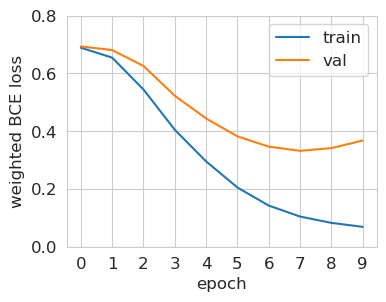

In [27]:
reload(models)
exceedance_threshold = 1.1
n_epoch = 10

predictor = models.FeedForwardClassifier(
    exceedance_threshold,
    4,
    gb1.AA,
    10,
    n_model=3,
    device=torch.device(0)
)
loss_tx2 = predictor.fit(trainseq_n, ytrain_n, n_epoch=n_epoch)

plt.figure(figsize=(4, 3))
plt.plot(loss_tx2[:, 0])
plt.plot(loss_tx2[:, 1])
plt.xticks(range(n_epoch))
plt.ylim([0, 0.8])
plt.xlabel('epoch');
plt.ylabel('weighted BCE loss');
plt.legend(['train', 'val']);

In [19]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)  # np.arange(0.2, 0.701, 0.005) in 03.08 results
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

# true means of design distributions
# temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, verbose=True)
# print('Max achievable mean label: {:.4f}'.format(np.max(list(temp2mean.values()))))

In [22]:
# oh.
np.mean(ytrain_n >= exceedance_threshold)

0.0078

In [20]:
# 12.19.24: nope not doing this with binary classifier
reload(models)
reload(gb1)

target_values = np.arange(0.0, 1.01, 0.02)
n_cal = 5000
n_trial = 500
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-121924.csv'.format(exceedance_threshold)
save_design_samples = False
load_design_samples = True

design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

df = gb1.run_pp_exceedance_selection_experiments(
    predictor,
    exceedance_threshold,
    temp2theta,
    target_values,
    n_cal=n_cal,
    n_trial=n_trial,
    pp_csv_fname=pp_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True
)

Selection quantity is probability of exceeding 1.1.
Range of provided target values: [0.000, 1.000].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.



KeyboardInterrupt



# 01.08.25

In [8]:
# load model
reload(models)
model = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model.load('gb1-h10-5k-030123')

In [7]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

In [140]:
reload(gb1)
# HERE: plot, run and compare PO

exceedance_threshold = 1.1
target_values = np.arange(0.0, 1.01, 0.02)
n_cal = 8000
n_train_lr = 3000
n_trial = 20
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-010825.csv'.format(exceedance_threshold)
design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

pp_df = gb1.run_selection_for_exceedance_with_calibration_data(
    model,
    temp2theta,
    target_values,
    exceedance_threshold=exceedance_threshold,
    n_cal=n_cal,
    n_trial=n_trial,
    n_train_lr=n_train_lr,
    pp_csv_fname=pp_csv_fname,
    self_normalize_weights=True,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True,
)

Selection quantity is probability of exceeding 1.1.
Range of provided target values: [0.000, 1.000].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.
Done with 20 trials for temperature 0.2000 (1 / 101) (16 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2050.npz.
Done with 20 trials for temperature 0.2050 (2 / 101) (32 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2100.npz.
Done with 20 trials for temperature 0.2100 (3 / 101) (48 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2150.npz.
Done with 20 trials for temperature 0.2150 (4 / 101) (64 s).
Saved

Done with 20 trials for temperature 0.3650 (34 / 101) (536 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3700.npz.
Done with 20 trials for temperature 0.3700 (35 / 101) (552 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3750.npz.
Done with 20 trials for temperature 0.3750 (36 / 101) (569 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3800.npz.
Done with 20 trials for temperature 0.3800 (37 / 101) (585 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3850.npz.
Done with 20 trials 

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5350.npz.
Done with 20 trials for temperature 0.5350 (68 / 101) (1088 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5400.npz.
Done with 20 trials for temperature 0.5400 (69 / 101) (1105 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5450.npz.
Done with 20 trials for temperature 0.5450 (70 / 101) (1122 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5500.npz.
Done with 20 trials for temperature 0.5500 (71 / 101) (1138 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.
Loaded 1000000 d

Done with 20 trials for temperature 0.7000 (101 / 101) (1626 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-010825.csv.


In [141]:
# load PP selection results, computed in gb1-022823 nb

temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, threshold=exceedance_threshold) 

pp_df = pd.read_csv(pp_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, temp2mean, n_trial, imp_or_pp='pp'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 51 target values in [0.00, 1.00], 20 trials, and alpha = 0.1
Done processing (2 s)


In [84]:
pp_df.head()

,tr0_pp_pval_temp0.2000,tr0_pp_pval_temp0.2050,tr0_pp_pval_temp0.2100,tr0_pp_pval_temp0.2150,tr0_pp_pval_temp0.2200,tr0_pp_pval_temp0.2250,tr0_pp_pval_temp0.2300,tr0_pp_pval_temp0.2350,tr0_pp_pval_temp0.2400,tr0_pp_pval_temp0.2450,...,tr19_pp_pval_temp0.6550,tr19_pp_pval_temp0.6600,tr19_pp_pval_temp0.6650,tr19_pp_pval_temp0.6700,tr19_pp_pval_temp0.6750,tr19_pp_pval_temp0.6800,tr19_pp_pval_temp0.6850,tr19_pp_pval_temp0.6900,tr19_pp_pval_temp0.6950,tr19_pp_pval_temp0.7000
0.00,0.0,0.0,7.739185e-47,9.152847e-45,0.0,0.0,0.0,0.0,0.0,2.741611e-194,...,2.081447e-92,0.002679,2.153442e-25,1.507899e-12,1.291889e-17,1.116595e-60,2.645304e-10,6.905304e-18,1.539105e-123,5.545037e-15
0.02,0.0,0.0,1.047707e-44,1.065155e-42,0.0,0.0,0.0,0.0,0.0,3.356486e-186,...,6.665936e-88,0.004325,7.806394e-24,1.139121e-11,2.020443e-16,9.136870e-57,1.323780e-09,5.558912e-17,4.851155e-117,5.918572e-14
0.04,0.0,0.0,1.259839e-42,1.103042e-40,0.0,0.0,0.0,0.0,0.0,2.754563e-178,...,1.638685e-83,0.006820,2.507131e-22,7.924395e-11,2.844259e-15,5.488493e-53,6.207517e-09,4.218723e-16,1.014201e-110,5.756264e-13
0.06,0.0,0.0,1.345653e-40,1.016502e-38,0.0,0.0,0.0,0.0,0.0,1.515369e-170,...,3.092315e-79,0.010512,7.134243e-21,5.077153e-10,3.604487e-14,2.420477e-49,2.727959e-08,3.018396e-15,1.406448e-104,5.101871e-12
0.08,0.0,0.0,1.276756e-38,8.336342e-37,0.0,0.0,0.0,0.0,0.0,5.588459e-163,...,4.479634e-75,0.015836,1.798877e-19,2.996393e-09,4.112686e-13,7.837601e-46,1.123669e-07,2.036089e-14,1.293794e-98,4.121389e-11


In [126]:
exceedance_threshold = -0.79
n_cal = 5000
n_train_lr = 500
_, calohe_nxlxa, calseq_n = gb1.sample_ohe_from_nuc_distribution(
    gb1.PNUC_NNK_LXA, n_cal, normalize=False, reject_stop_codon=True
)
ycal_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in calseq_n])
ycal_n = (ycal_n >= exceedance_threshold).astype(float)
print(np.sum(ycal_n))

shuffle_idx = np.random.permutation(n_cal)
train_idx, cal_idx = shuffle_idx[: n_train_lr], shuffle_idx[n_train_lr :]
ytrain_n = ycal_n[train_idx]
ycal_n = ycal_n[cal_idx]
print(np.sum(ytrain_n), np.sum(ycal_n))

220.0
29.0 191.0


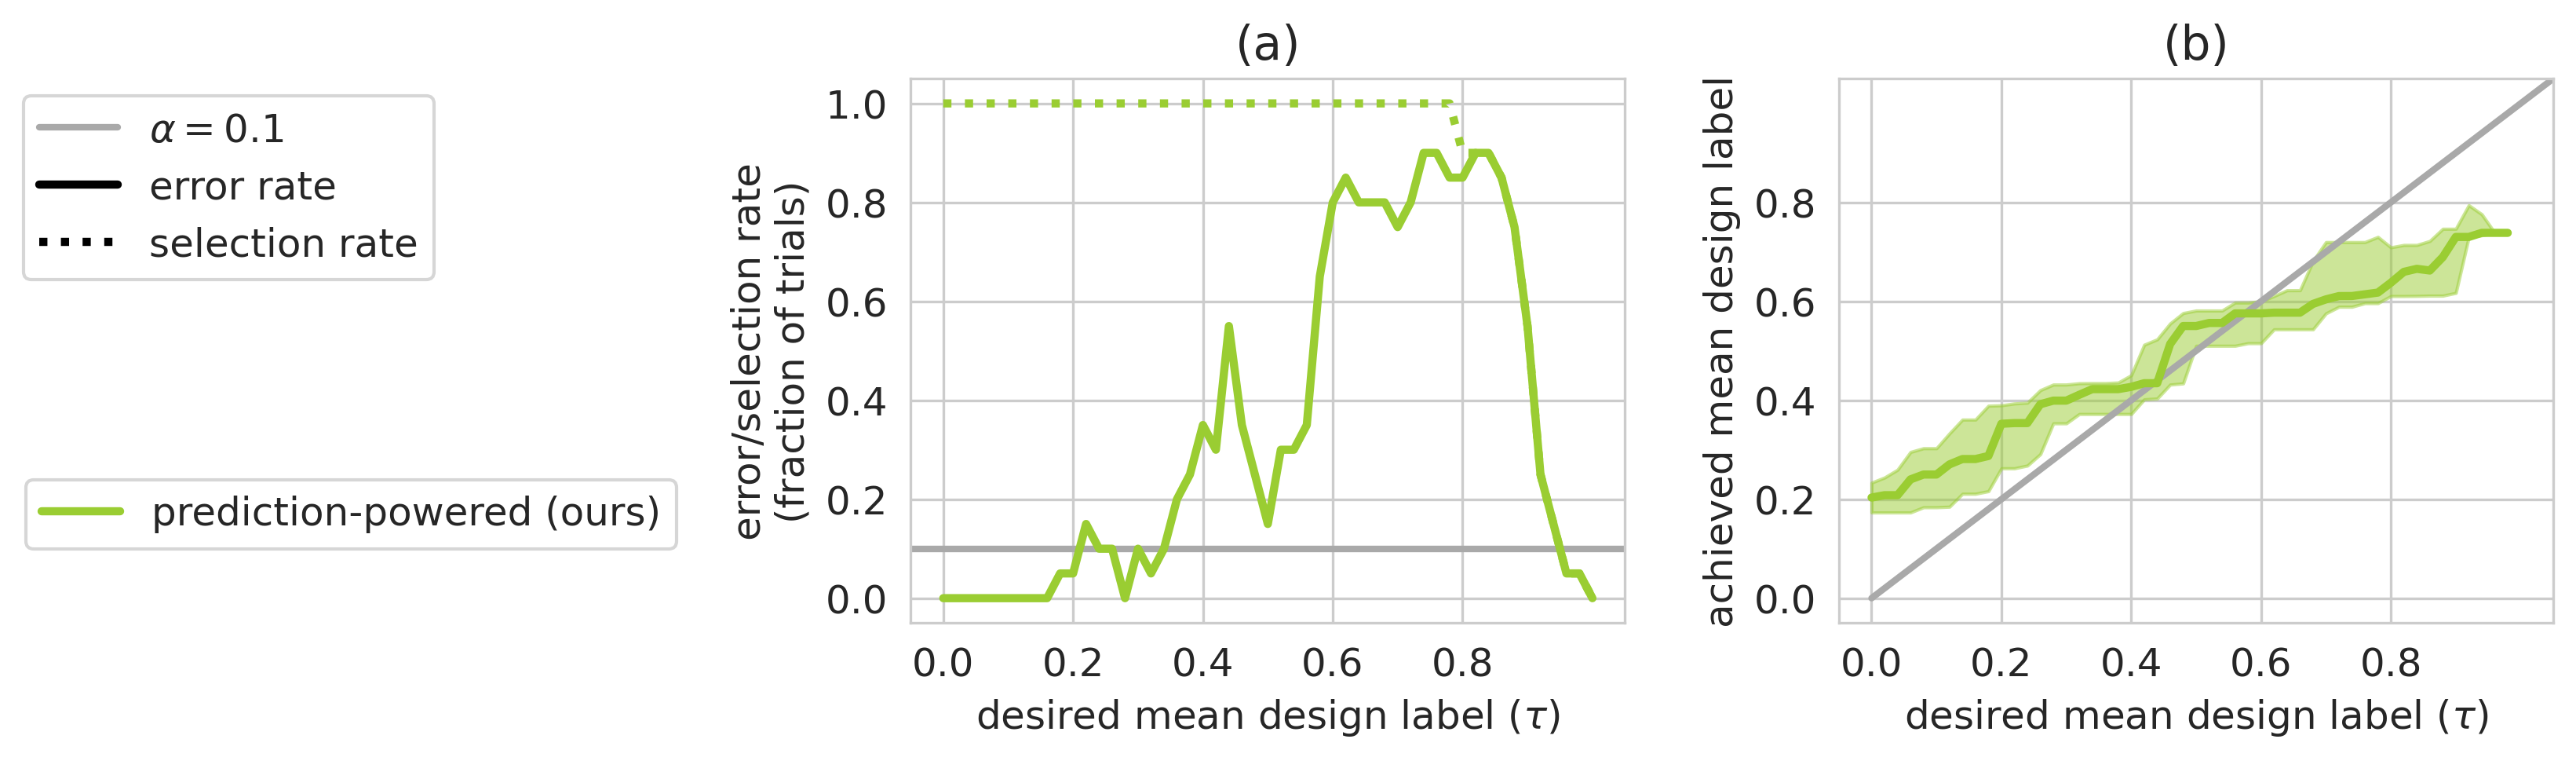

In [142]:
# one-row figure
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
ax0 = axs[0]
ax1 = axs[1]
fig.subplots_adjust(wspace=0.3)

alpha = 0.1
wf_type = 'cs'
imp_color = 'darkorange'
pp_color = 'yellowgreen'
wf_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'darkgray'

lw = 2.5
legend_fs = 12
imp_xlim = [-0.05, 1.05]
imp_xticks = np.arange(0, 1., 0.2)
pp_xlim = [-0.05, 1.05]
pp_xticks = np.arange(0, 1., 0.2)

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====
# ax0.plot(target_values, imperr_v, c=imp_color, linewidth=lw);
# ax0.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=lw);

# for q_idx, q in enumerate(qs):
#     _, wferr_v, wfdisc_v, _ = wf_type2results[wf_type][q]
#     ax0.plot(target_values, wferr_v, c=wf_colors[q_idx], linewidth=lw);
#     ax0.plot(target_values, wfdisc_v, ':', c=wf_colors[q_idx], linewidth=lw);
    
ax0.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));

ax0.plot(target_values, pperr_v, c=pp_color, linewidth=lw);
ax0.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=lw);

# ax0.plot(target_values, qcerr_v, c='steelblue', linewidth=lw);
# ax0.plot(target_values, qcdisc_v, ':', c='steelblue', linewidth=lw);

# dummy so get legend labels
ax0.plot(-1, -1, linestyle='-', color='k', linewidth=lw, label='error rate')
ax0.plot(-1, -1, linestyle=':', color='k', linewidth=lw, label='selection rate')

ax0.set_ylim([-0.05, 1.05])
ax0.set_yticks(np.arange(0, 1.05, 0.2))
ax0.set_xlim(imp_xlim)
ax0.set_xticks(imp_xticks)
ax0.set_ylabel('error/selection rate\n(fraction of trials)');
ax0.set_xlabel(r'desired mean design label ($\tau$)');
ax0.set_title('(a)')
ax0.legend(fontsize=legend_fs, loc='center left', bbox_to_anchor=(-1.27, 0.8))
# ax0.legend(fontsize=legend_fs, loc='upper left', bbox_to_anchor=(0.0, 0.95))


# ===== subplot (b) =====

ax1.plot([0, 1.5], [0, 1.5], '-', c=dark_line_color, alpha=1, linewidth=2);
# ax1.plot(
#     target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
#     c=imp_color, label='prediction-only', linewidth=lw,
# )
# ax1.fill_between(
#     target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
#     color=imp_color, alpha=0.5,
# )

ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (ours)', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

# for q_idx, q in enumerate(qs):
#     # qa = 0.3 + (1 - q) * 0.7
#     wfworst_v, _, _, _ = wf_type2results[wf_type][q]
#     ax1.plot(
#         target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
#         c=wf_colors[q_idx], label=f'GMM forecasts, q = {q}', linewidth=lw,
#     )
#     ax1.fill_between(
#         target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
#         [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
#         color=wf_colors[q_idx], alpha=0.5,
#     )

    
# ax1.plot(
#     target_values, [np.median(worst) if len(worst) else np.nan for worst in qcworst_v],
#     c='steelblue', label='calibrated forecasts', linewidth=lw,
# )
# ax1.fill_between(
#     target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in qcworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in qcworst_v],
#     color='steelblue', alpha=0.5,
# )

ax1.set_xlim(imp_xlim)
ax1.set_ylim(imp_xlim)
ax1.set_xticks(imp_xticks)
ax1.set_yticks(imp_xticks)
# ax1.legend(fontsize=legend_fs, loc='center left', bbox_to_anchor=(1.05, 0.5))
legend = ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.6, 0.2))

# font_properties = FontProperties()
# font_properties.set_family('monospace')
# font_properties.set_name('Courier')
# legend.get_texts()[2].set_fontproperties(font_properties)

ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');


In [ ]:
# sample calibration data from NNK
# HERE debug
_, calohe_nxlxa, calseq_n = gb1.sample_ohe_from_nuc_distribution(
    PNUC_NNK_LXA, n_cal, normalize=False, reject_stop_codon=True
)
ycal_n = np.array([SEQ2YVAR[seq][0] for seq in calseq_n])
ycal_n = (ycal_n >= exceedance_threshold).astype(float)

# ----- train exceedance predictor for this trial -----
predictor = ExceedancePredictor(model, exceedance_threshold)
sampled_both_labels = False
while not sampled_both_labels:  
    shuffle_idx = np.random.permutation(n_cal)
    train_idx, cal_idx = shuffle_idx[: n_train_lr], shuffle_idx[n_train_lr :]
    sampled_both_labels = any(ycal_n[train_idx]) and any(ycal_n[cal_idx])

trainohe_nxlxa = calohe_nxlxa[train_idx]
ytrain_n = ycal_n[train_idx]
# n1 = np.sum(ytrain_n)
# n0 = n_train_lr - n1
# w1 = n_train_lr / (2 * n1)
# w0 = n_train_lr / (2 * n0)
# w_n = [w1 if y == 1 else w0 for y in ytrain_n]
# assert(np.abs(np.sum(w_n) - n_train_lr) < 1e-6)
predictor.fit(trainohe_nxlxa, ytrain_n)  # , weight_n=w_n)

# use the remaining data for calibration
calohe_nxlxa = calohe_nxlxa[cal_idx]
ycal_n = ycal_n[cal_idx]